# Analyse des données BTC/USD

---
## 1. Chargement des données

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Add, Input, Activation, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
import datetime

df = pd.read_csv('data/btcusd_1-min_data.csv')

print(f"Nb lines: {len(df)}")
print(df.head())
print(df.info())

Nb lines: 7258717
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7258717 entries, 0 to 7258716
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 332.3 MB
None


---
## 2. Visualisation du prix en fonction du temps

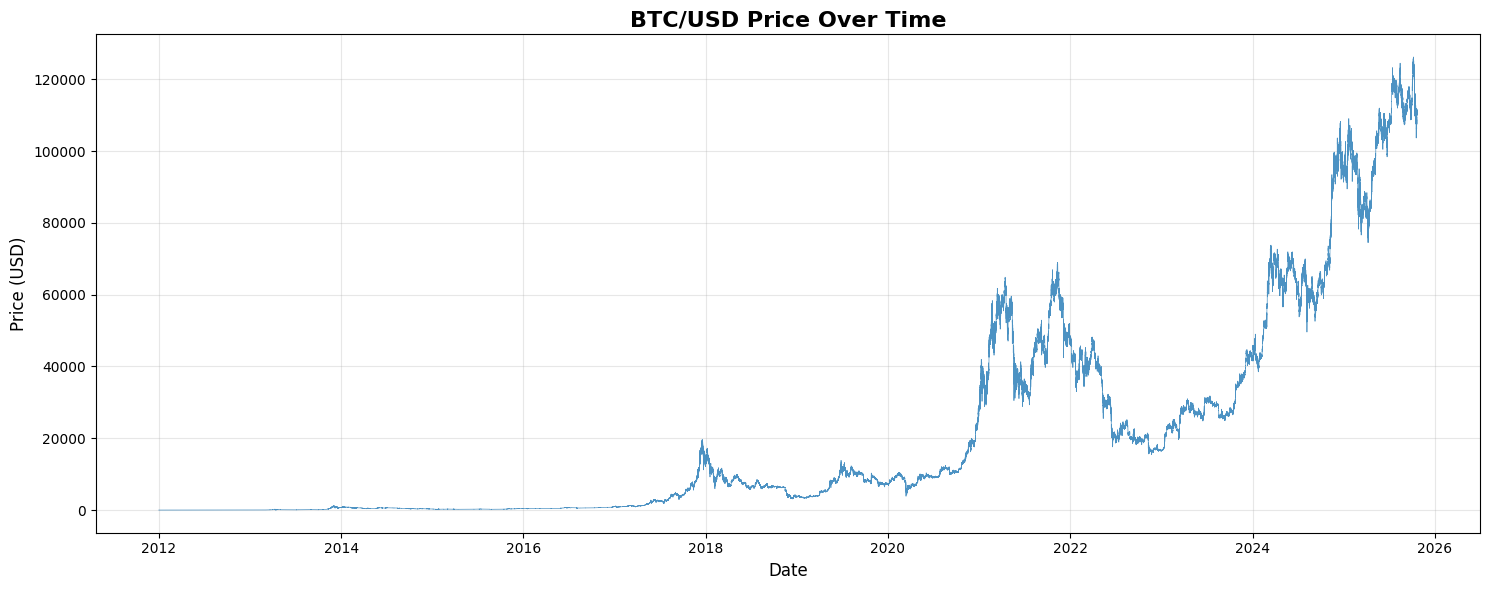

min price: $3.8
max price: $126202.0
mean: $20605.617259248593
std dev: $29161.716912376545


In [ ]:
# timestamp to datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')

# plot
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['Close'], linewidth=0.5, alpha=0.8)
plt.title('BTC/USD Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/01_btc_price_history.png', dpi=100, bbox_inches='tight')
plt.show()

# stats
print(f"min price: ${df['Close'].min()}")
print(f"max price: ${df['Close'].max()}")
print(f"mean: ${df['Close'].mean()}")
print(f"std dev: ${df['Close'].std()}")

---
## 3. Préparation des données pour LSTM

In [20]:
# Increase to 20000 values for Very Deep Learning
data = df['Close'].values[-20000:].reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"data shape: {scaled_data.shape}")
print(f"min {scaled_data.min()}, max {scaled_data.max()}")

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Increase seq_length from 60 to 120
seq_length = 120
X, y = create_sequences(scaled_data, seq_length)

X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\ntraining shape {X_train.shape}")
print(f"test shape {X_test.shape}")

data shape: (20000, 1)
min 0.0, max 1.0

training shape (15904, 120, 1)
test shape (3976, 120, 1)


---
## 4. Construction du modèle LSTM

In [21]:
input_layer = Input(shape=(X_train.shape[1], 1))

bloc1 = Conv1D(filters=64, kernel_size=3, padding='same')(input_layer)
bloc1 = BatchNormalization()(bloc1)
bloc1 = Activation('relu')(bloc1)
bloc1 = Dropout(0.2)(bloc1)

bloc2 = Conv1D(filters=64, kernel_size=3, padding='same')(bloc1)
bloc2 = BatchNormalization()(bloc2)
bloc2 = Activation('relu')(bloc2)
bloc2 = Dropout(0.2)(bloc2)

residual1 = Add()([bloc1, bloc2])

lstm1 = LSTM(units=100, return_sequences=True)(bloc2)
lstm1 = Dropout(0.3)(lstm1)

lstm2 = LSTM(units=80, return_sequences=True)(lstm1)
lstm2 = Dropout(0.3)(lstm2)

lstm1_adapted = Conv1D(filters=80, kernel_size=1, padding='same')(lstm1)
residual2 = Add()([lstm1_adapted, lstm2])

lstm3 = LSTM(units=60, return_sequences=False)(residual2)
lstm3 = Dropout(0.3)(lstm3)

dense1 = Dense(units=50, activation='relu')(lstm3)
dense1 = Dropout(0.2)(dense1)

dense2 = Dense(units=25, activation='relu')(dense1)

output = Dense(units=1)(dense2)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 120, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 120, 64)   │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 120, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 120, 64)   │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 120, 64)   │     12,352 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 120, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 120, 64)   │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 120, 100)  │     66,000 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 120, 100)  │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 120, 80)   │     57,920 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 120, 80)   │      8,080 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 120, 80)   │          0 │ lstm_6[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 120, 80)   │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     33,840 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 60)        │          0 │ lstm_7[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │      3,050 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 50)        │          0 │ dense_5[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │      1,275 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 183,311 (716.06 KB)

 Trainable params: 183,055 (715.06 KB)

 Non-trainable params: 256 (1.00 KB)

---
## 5. Entraînement du modèle

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    ModelCheckpoint(
        filepath='best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/02_training_history.png', dpi=100, bbox_inches='tight')
plt.show()

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0685 - mae: 0.1633
Epoch 1: val_loss improved from None to 0.06620, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - loss: 0.0240 - mae: 0.0985 - val_loss: 0.0662 - val_mae: 0.2534 - learning_rate: 0.0010
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0055 - mae: 0.0542
Epoch 2: val_loss improved from 0.06620 to 0.04326, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - loss: 0.0046 - mae: 0.0493 - val_loss: 0.0433 - val_mae: 0.2064 - learning_rate: 0.0010
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0032 - mae: 0.0406
Epoch 3: val_loss improved from 0.04326 to 0.01413, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - loss: 0.0028 - mae: 0.0383 - val_loss: 0.0141 - val_mae: 0.1111 - learning_rate: 0.0010
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0024 - mae: 0.

---
## 6. Prédictions et évaluation

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
test data:
MSE: $441345.9396129279
MAE: $577.4915508677065
RMSE: $664.3387235536762
R2 Score: 0.8453992244795203


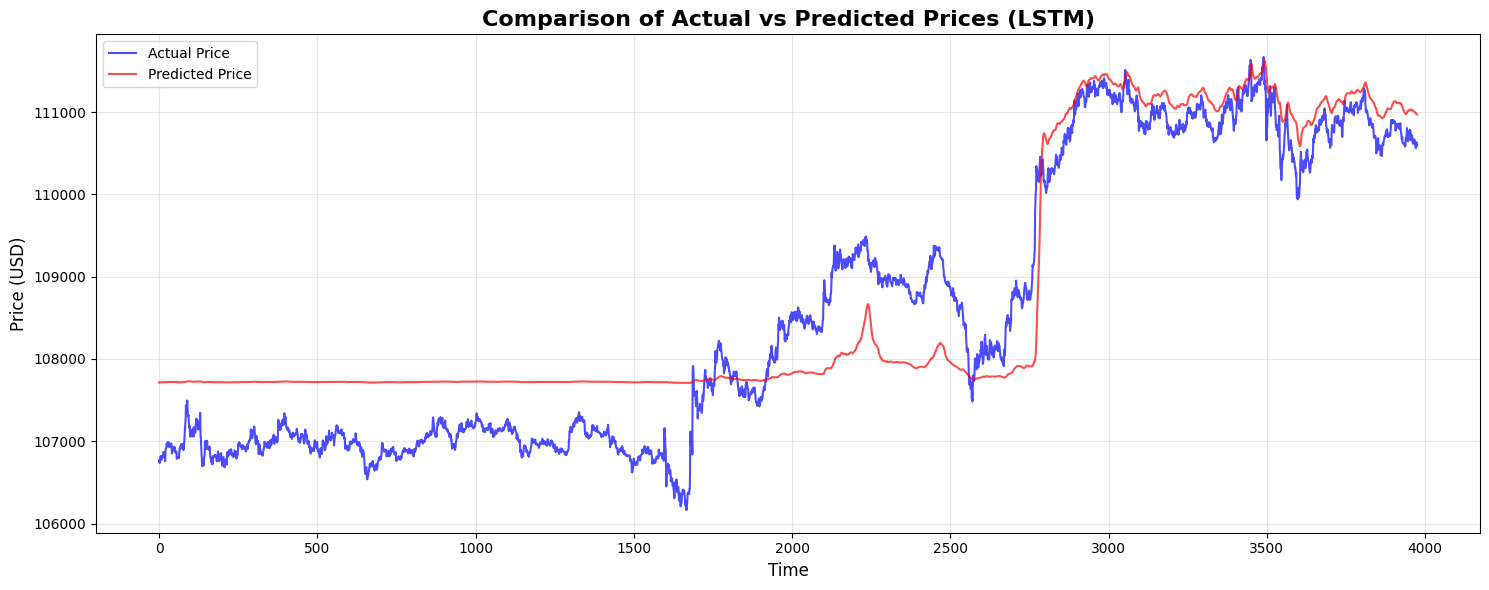

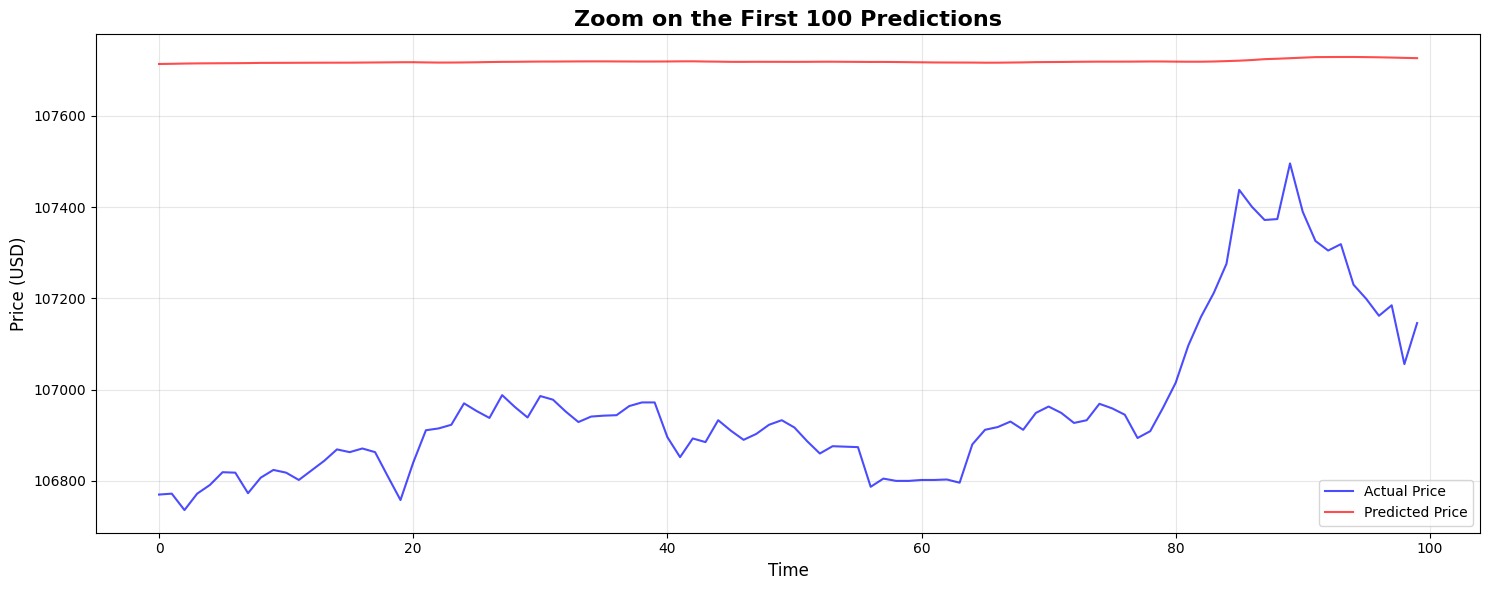

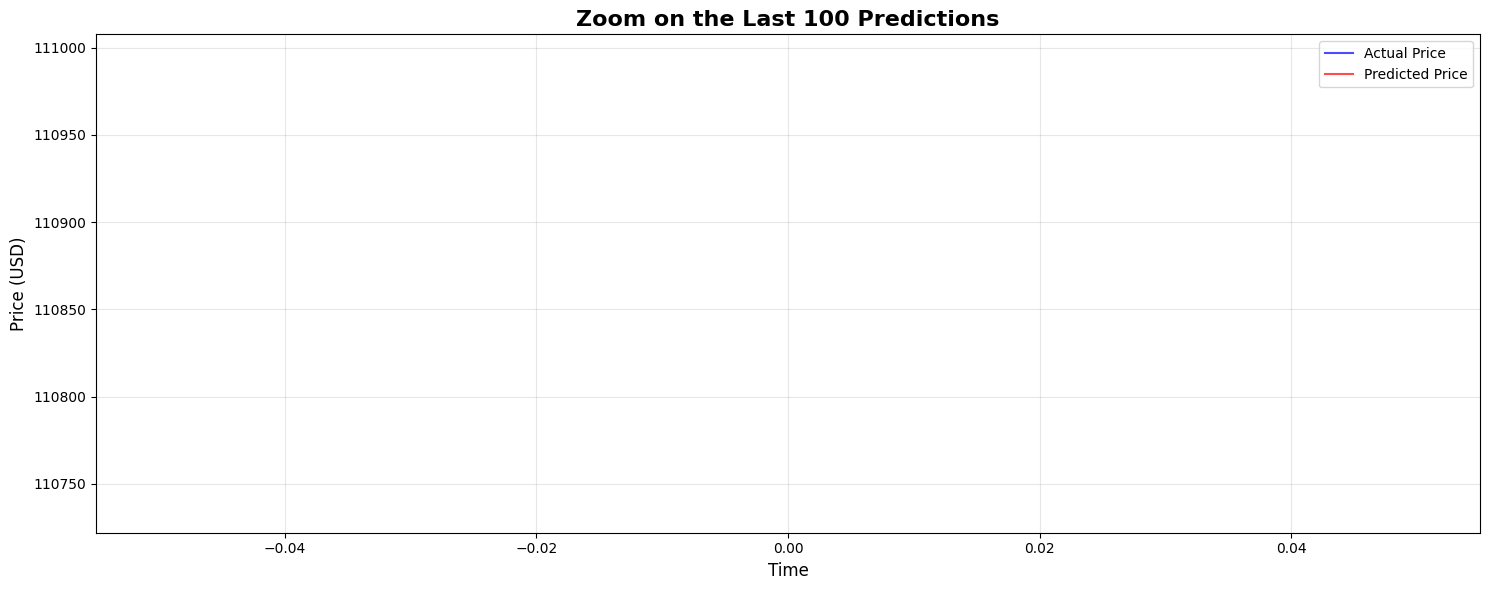

In [ ]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"test data:")
print(f"MSE: ${mse}")
print(f"MAE: ${mae}")
print(f"RMSE: ${rmse}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual vs Predicted Prices (LSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/03_predictions_full.png', dpi=100, bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:100], label='Actual Price', color='blue', alpha=0.7)
plt.plot(predictions[:100], label='Predicted Price', color='red', alpha=0.7)
plt.title('Zoom on the First 100 Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/04_predictions_first_100.png', dpi=100, bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[-100], label='Actual Price', color='blue', alpha=0.7)
plt.plot(predictions[-100], label='Predicted Price', color='red', alpha=0.7)
plt.title('Zoom on the Last 100 Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/05_predictions_last_100.png', dpi=100, bbox_inches='tight')
plt.show()

---
## 7. Visualisation avec TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit